<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/05_trasnfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with Tensorflow Part 2: Fine-tuning.

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of tranfer learning **Fine-tuning**

In [1]:
# Check if we are using GPU.
!nvidia-smi

Sun Aug 24 03:39:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Creating helper functions.

In the previous notebooks, we've created a bunch of helper functions, now we coulld write them up but it's better we import them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-24 03:39:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-24 03:39:33 (134 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Importing helper functions to use in this notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

 ## Get some data.

We will get 10% of training data of 10 classes of Food101

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-08-24 03:39:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2025-08-24 03:39:39 (164 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# walk through diercitory.
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Create training and test directory paths.

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"



In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# See an example of a batch of data.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.10181770e+01 4.60181770e+01 2.33753185e+01]
   [4.31211739e+01 4.67640305e+01 2.44783154e+01]
   [4.83453445e+01 5.07340546e+01 2.86664543e+01]
   ...
   [2.16635780e+01 3.38287849e+01 2.27617397e+01]
   [2.18364239e+01 3.47649956e+01 2.07350044e+01]
   [2.39206276e+01 3.72063408e+01 2.04206276e+01]]

  [[4.97787018e+01 5.19215584e+01 2.79929848e+01]
   [4.89489822e+01 5.10918388e+01 2.71632652e+01]
   [4.65513420e+01 4.71674118e+01 2.32933655e+01]
   ...
   [1.77072144e+01 3.07731953e+01 2.42519093e+01]
   [1.60714283e+01 2.84285698e+01 2.41428566e+01]
   [2.11563015e+01 3.35134430e+01 3.09420166e+01]]

  [[5.06957893e+01 5.04815063e+01 2.20529327e+01]
   [4.35733414e+01 4.25733414e+01 1.45733423e+01]
   [4.57024879e+01 4.36119270e+01 1.75749378e+01]
   ...
   [3.23227692e+01 3.81177483e+01 2.93527565e+01]
   [3.35455818e+01 3.98312950e+01 3.35268288e+01]
   [2.94154663e+01 3.45497017e+01 3.05755692e+01]]

  ...

  [[1.75853058e+02 8.66387787e+01 7.32815704e+01]
   [1

In [10]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Building a transfer learning model using the Keras Functional API. Feature Extraction

In [11]:
# 1. Create base model with tf.keras.applications.
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

# 2. Freeze the base model(so the underlying pre-trained patterins arein't updated)
base_model.trainable = False

# 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs.
# x = tf.keras.layers.preprocessing.Rescaling(1./255)

# 4. pass the inpusts to beh base_model.
x = base_model(inputs)
print(f"Shape after base model: {x.shape}")

# 5. Average pool the outputs of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 7. Combine the inputs with the outputs into a model.
model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after base model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)


In [12]:
# Compile the model.
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# fit the model.
model_0_history = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    validation_data = test_data,
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2283 - loss: 2.1230 - val_accuracy: 0.7076 - val_loss: 1.3235
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.7467 - loss: 1.1982 - val_accuracy: 0.8128 - val_loss: 0.8793
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.8210 - loss: 0.8011 - val_accuracy: 0.8384 - val_loss: 0.7031
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.8676 - loss: 0.6604 - val_accuracy: 0.8548 - val_loss: 0.6119
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.8778 - loss: 0.5694 - val_accuracy: 0.8664 - val_loss: 0.5567


In [13]:
# evaluate our model.
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8640 - loss: 0.5502


[0.5566633343696594, 0.8664000034332275]

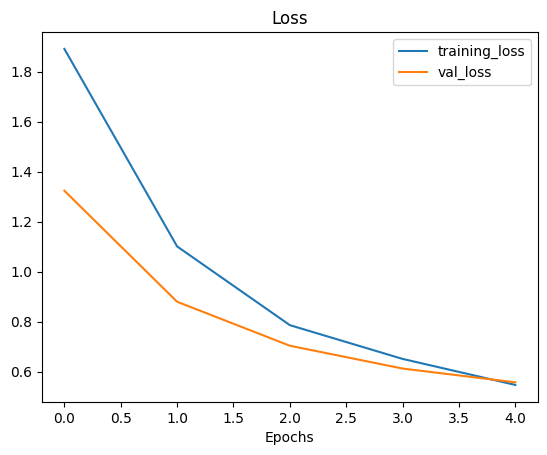

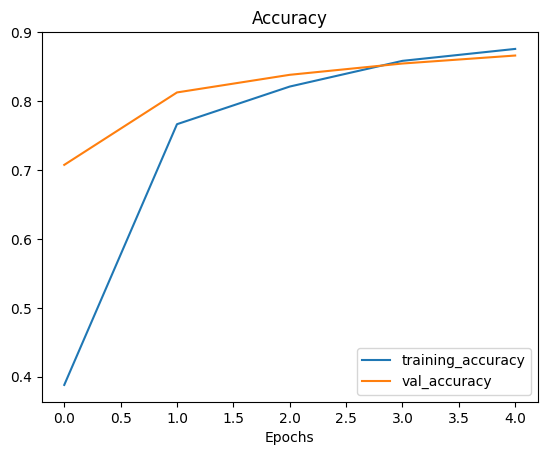

In [14]:
# plot loss curves.
plot_loss_curves(model_0_history)

In [15]:
# Check layers in our base model.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

## Getting a feature vector from a trained model.

Let's demonsrate the Gloabl Average Pooling 2D layer...


We have a tensor after our model goes through 'base_model' it has a shape of (None, 7, 7, 1280).

when it passes through our GlobalAveragePooling2D, it turns into (None, 1280)

In [16]:
# Define input shape.
input_shape = (1, 4, 4, 3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: 'n {input_tensor}")


# Pass the random tensor through a global average pooling 2d.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Average Pooling 2D: {global_average_pooled_tensor.shape}")
print(f"2D Global Average Pooling 2D: {global_average_pooled_tensor}")

# check the shape of the d/f tensor.
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Average Pooling 2D: {global_average_pooled_tensor.shape}")

Random input tensor: 'n [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Average Pooling 2D: (1, 3)
2D Global Average Pooling 2D: [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Average Pooling 2D: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer.
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Lets try to use the GlobalMax2D and see how it works.

In [18]:
# Define input shape.
input_shape = (1, 4, 4, 3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: 'n {input_tensor}")


# Pass the random tensor through a global max pooling 2d.
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Max Pooling 2D: {global_max_pooled_tensor.shape}")
print(f"2D Global Max Pooling 2D: {global_max_pooled_tensor}")

# check the shape of the d/f tensor.
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Max Pooling 2D: {global_max_pooled_tensor.shape}")

Random input tensor: 'n [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Max Pooling 2D: (1, 3)
2D Global Max Pooling 2D: [[0.9058464 1.1603122 1.6994323]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Max Pooling 2D: (1, 3)


## Running a series of transfer Learning experiments.

We've seen the incredibile results transfer learning can get with only 10% f the training data, but how does it go with 1% of the training data. How about we setup a bonth of experiments to find out.

1. 'model_1' - use feature extraction tranfer learning with 1% of the training data with data augmentation.
2. 'model_2' - use feature extraction transler learning with 10% of the training with data augmetnaion.
3. 'model_3' - use fin-tuning tranfer learning on 10% of the training data with data augmentation.
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmetnaion.

In [19]:
# Download and unzip data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2025-08-24 03:42:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   135MB/s    in 0.9s    

2025-08-24 03:42:01 (135 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Walk through the directory.
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [21]:
# Create training and test dirs.
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


In [22]:
# How many images we are working with ?

import pathlib
data_dir = pathlib.Path(train_dir_1_percent)

image_count_dict = {}

for dirpath in data_dir.glob("*"):
  image_count = len(list(dirpath.glob("*")))
  image_count_dict[dirpath.name] = image_count

image_count_dict

{'fried_rice': 7,
 'sushi': 7,
 'chicken_wings': 7,
 'hamburger': 7,
 'grilled_salmon': 7,
 'ramen': 7,
 'pizza': 7,
 'ice_cream': 7,
 'steak': 7,
 'chicken_curry': 7}

In [23]:
## Setup data loaders.

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
print("Number of batches in train data: ", len(train_data_1_percent))
print("Number of batches in test data: ", len(test_data_1_percent))

Number of batches in train data:  3
Number of batches in test data:  79


In [25]:
## Adding data augmentation right into our model.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, RandomContrast
# from tensorflow.keras.layers.experimental import preprocessing
# Create data augmentation stage with horizontal flipping, rotations, zooms.

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)
], name="data_augmentation")

## Let's visualize our data augmentation layer on a bunch of images.

10_food_classes_1_percent/train/chicken_curry
389273.jpg


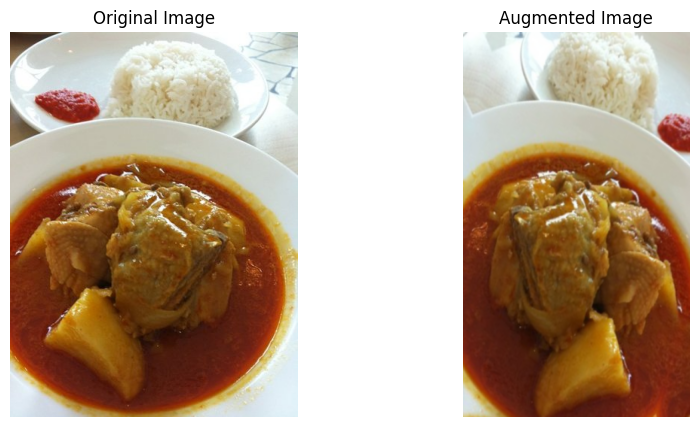

In [26]:
# View a random image and compare it to its augmented version.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)

# Read and plot in the random image
random_image = random.choice(os.listdir(target_dir))
print(random_image)
random_image_path = target_dir + "/" + random_image

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_img) / 255.)
plt.title("Augmented Image")
plt.axis("off")

plt.show()

# Building our Model_1 Transfer learning with EfficientNetB0 with Data Augmentation as a layer.

In [27]:
# Setup the input shape base model, freezing the base model layers.

INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

base_model.trainable = False

# Create input layer.
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")

# add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x, training = False)

# Pool output features of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# put a dense layer as output.
outputs = layers.Dense(10, activation="softmax", name="output layer")(x)


model = tf.keras.Model(inputs, outputs)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 512, 382, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>',)
  • kwargs={'mask': 'None'}

In [ ]:
# compile model.
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
Model_1_history = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    validation_data = test_data_1_percent,
    validation_steps = int(0.15 * len(test_data_1_percent)),
)